## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

C:\Users\draj2\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Dataset

In [2]:
df = pd.read_csv(r'C:\Users\draj2\Downloads\AB_Test_Results.csv')

## Dataset Check

In [3]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [4]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [5]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [6]:
# taking look at the distribution of the number of unique groups for each user
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [7]:
# also look in relative terms
double_variant_count / double_variant_count.sum()

1    0.756325
2    0.243675
Name: VARIANT_NAME, dtype: float64

In [8]:
# first, let's see which users have 1 ab test group
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
# and then take only these users
single_variant_users = single_variant_users[single_variant_users]

In [9]:
# leave only records with users with the 1st ab test group
df = df[df['USER_ID'].isin(single_variant_users.index)]
# just in case, check that the number of users matches what it was before the exception
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

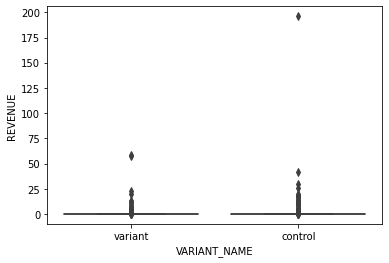

In [8]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

In [9]:
df.sort_values(by='REVENUE', ascending=False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
6447,2881,variant,58.63
7642,7206,variant,57.46
9421,6792,control,41.53
8168,2166,control,29.32
9125,831,control,25.98
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56


In [13]:
df = df[df['USER_ID'] != 4241]

([<matplotlib.axis.XTick at 0x121b78a0460>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

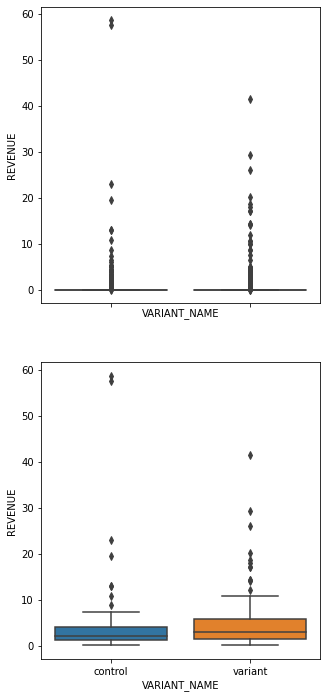

In [14]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

In [15]:
# let's see if there are users who have records with zero and positive revenue
(df.loc[
    (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)), 
    'USER_ID'
]).count()

52

In [16]:
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

([<matplotlib.axis.XTick at 0x121b7a5e160>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

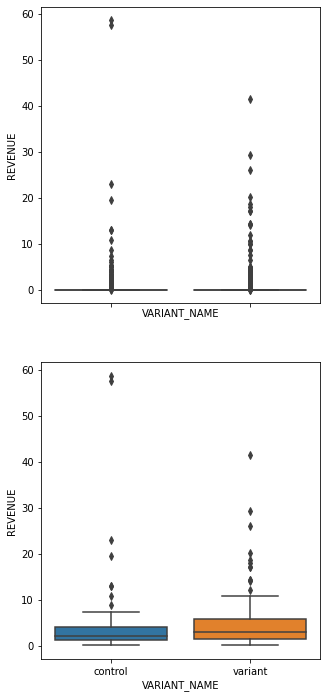

In [16]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

In [17]:
# get metrics by groups
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

# create two additional metrics to see relative changes
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

# add them to the rest of the metrics in a separate group
all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                         per_user          
             nunique     sum      mean median count    orders   revenue
VARIANT_NAME                                                           
control         3930  446.99  0.089703    0.0  4983  1.267939  0.113738
variant         3933  351.47  0.070084    0.0  5015  1.275108  0.089364

In [18]:
# get metrics by groups
paid_stat = df.loc[df.REVENUE != 0].groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                                                     'REVENUE': ['sum', 'mean', 'median', 'count']})

# add two additional metrics to see relative changes
orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stat

USER_ID REVENUE                         per_user          
             nunique     sum      mean median count    orders   revenue
VARIANT_NAME                                                           
control           79  446.99  5.658101   2.93    79  1.000000  5.658101
variant           71  351.47  4.881528   2.17    72  1.014085  4.950282

## Let's look at the distributions of all and only paying users

C:\Users\draj2\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\draj2\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\draj2\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

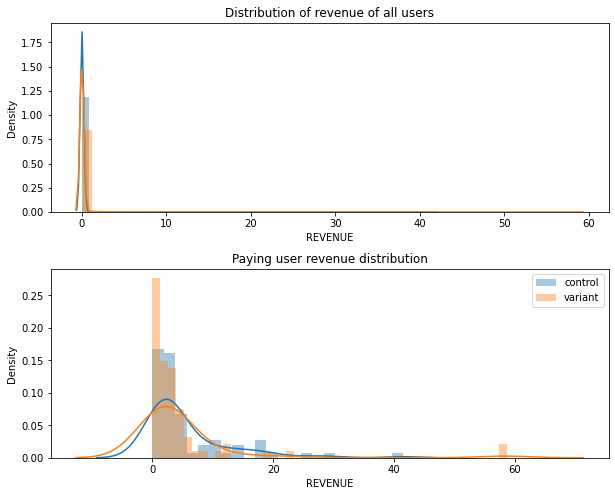

In [19]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

## Statistical Analysis 

#### Checking if the distribution is normal

In [20]:
shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

C:\Users\draj2\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.027037441730499268, pvalue=0.0)

The null hypothesis about the normal distribution of the data is rejected

#### Mann-Whitney test

In [21]:
(df['REVENUE'] == 0).value_counts()

True     9847
False     151
Name: REVENUE, dtype: int64

Let's first check on the data of all users

In [22]:
mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=12475728.0, pvalue=0.5300041525838701)

And only those who pay

In [23]:
mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'], 
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])

MannwhitneyuResult(statistic=2404.0, pvalue=0.10145877111519161)

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [24]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Let's generate samples for all users

In [25]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

And only for the paying users

In [26]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

Let's look at the distribution of means in the ab test groups

Text(0.5, 1.0, 'Sample mean distribution for all users')

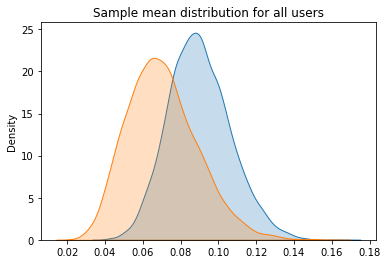

In [27]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

Text(0.5, 1.0, 'Sample mean distribution for paying users')

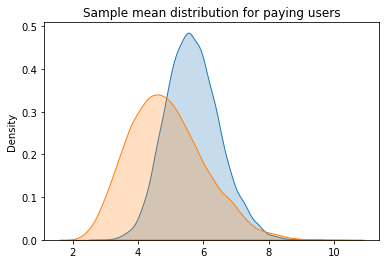

In [28]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

In [29]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=False).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

array([-0.06622252,  0.03008547])

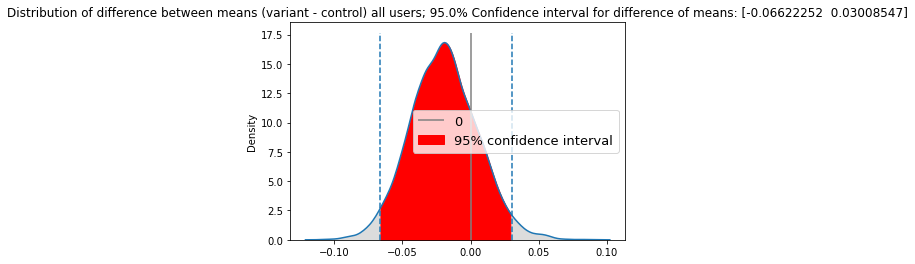

In [30]:
plot_distribution_and_stat_intervals(
    np.mean(variant, axis=1), 
    np.mean(control, axis=1),
    title='all users'
)

# f, ax = plt.subplots()
# get data for coloring confidence intervals
# points = sns.kdeplot(np.mean(variant, axis=1) - np.mean(control, axis=1), shade=True).get_lines()[0].get_data()
# np.mean(variant, axis=1) - np.mean(control, axis=1)

### Let's build a graph of the distribution of the difference in the means and get a confidence interval For all users

array([-3.43661041,  2.1545734 ])

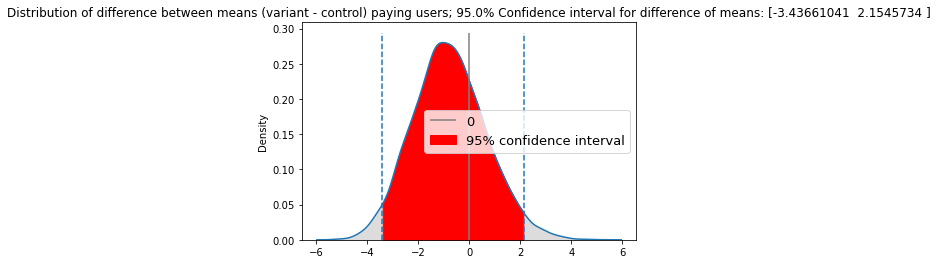

In [31]:
plot_distribution_and_stat_intervals(
    np.mean(variant_paid, axis=1), 
    np.mean(control_paid, axis=1), 
    title='paying users'
)